In [1]:
import os
import errno
import numpy as np 
import xarray as xr
import deepcell

In [3]:
# load data
#data_dir = '/data/patricia/20200320_Test_Run/'
data_dir = '/data/segmentation/20200227_IF_Testing/melanoma/'
#data_dir = '/data/alex/2020325_test_image/'
#data_dir = '/data/segmentation/20200429_cHL/'
data_dir = '/data/reema/20200422_test/'

In [24]:
cohort_xr = xr.open_dataarray(data_dir + 'deepcell_input.xr')
cohort_xr.shape

(6, 1024, 1024, 2)

In [25]:
# import copy
# temp_dna = copy.copy(cohort_xr[:, :, :, 1].values)
# cohort_xr[:, :, :, 1] = cohort_xr[:, :, :, 0]
# cohort_xr[:, :, :, 0] = temp_dna

In [5]:
from skimage.transform import resize
bigger_vals = resize(cohort_xr.values, [cohort_xr.shape[0], cohort_xr.shape[1] * 2, 
                                        cohort_xr.shape[2] * 2, cohort_xr.shape[3]], 
                     order=1, preserve_range=True)

In [4]:
# whole-cell model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights("/data/models/20200227_IF_Training/20200315_IF_Training_6_deep_watershed_updated.h5")

W0507 01:11:31.853782 140333411456832 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# mibi friendly model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights("/data/models/20200227_IF_Training/20200506_MIBI_combined_deep_watershed.h5")

W0507 21:10:09.057572 140566424741696 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 3s 0us/step


In [5]:
# decidua model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 6),
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights("/data/models/20191113_Decidua_Shirley_Relabel/Decidua_caliban_v4_blanked_fix2_stride_0.5_deep_watershed_pixel_transform_20_epoch.h5")

W0317 02:00:36.740812 139780376278848 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
from deepcell_toolbox.utils import tile_image, untile_image

In [28]:
test_data, test_info = tile_image(cohort_xr.values[:, ...], (256, 256), stride_ratio=0.75)

In [29]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = model.predict(test_data)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (150, 256, 256, 1) in 1.2707178540003952 seconds.


In [30]:
inner_distance, outer_distance, fgbg, pixelwise = test_images

In [31]:
inner_distance_untile = untile_image(inner_distance, test_info, (256, 256), "float32")
outer_distance_untile = untile_image(outer_distance, test_info, (256, 256), "float32")
pixelwise_untile = untile_image(pixelwise, test_info, (256, 256), "float32")
fgbg_untile = untile_image(fgbg, test_info, (256, 256), "float32")
pixelwise_sum = pixelwise_untile[:, :, :, :1] + pixelwise_untile[:, :, :, 1:2] 

In [32]:
combined = np.concatenate((pixelwise_untile[:, :, :, 1:2], pixelwise_untile[:, :, :, 0:1], 
                           inner_distance_untile, outer_distance_untile, fgbg_untile[:, :, :, 1:2],
                          pixelwise_sum), axis=-1)
combined.shape

(6, 1024, 1024, 6)

In [13]:
combined = resize(combined, [combined.shape[0], combined.shape[1] / 2, 
                             combined.shape[2] / 2, combined.shape[3]], order=1, preserve_range=True)

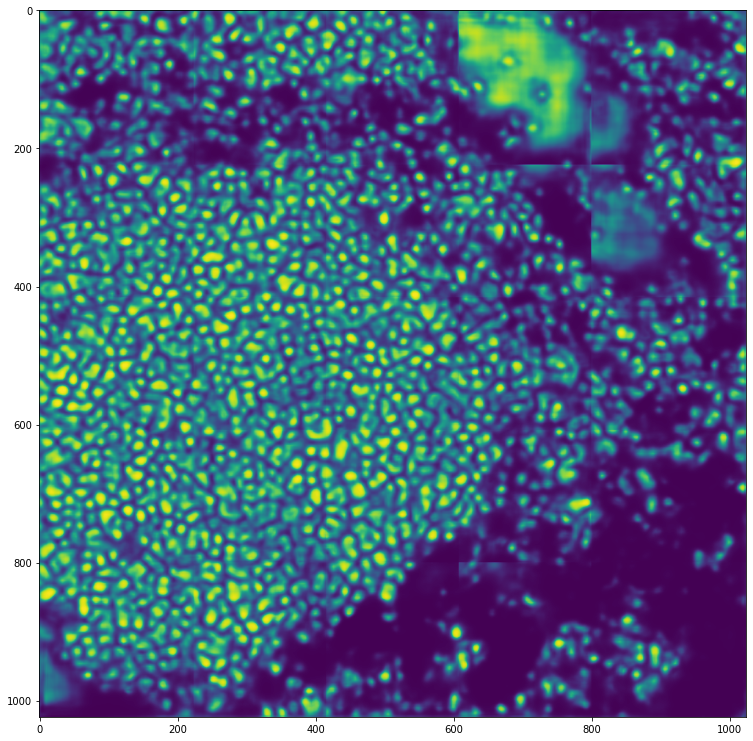

In [35]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(combined[3, :, :, 0])

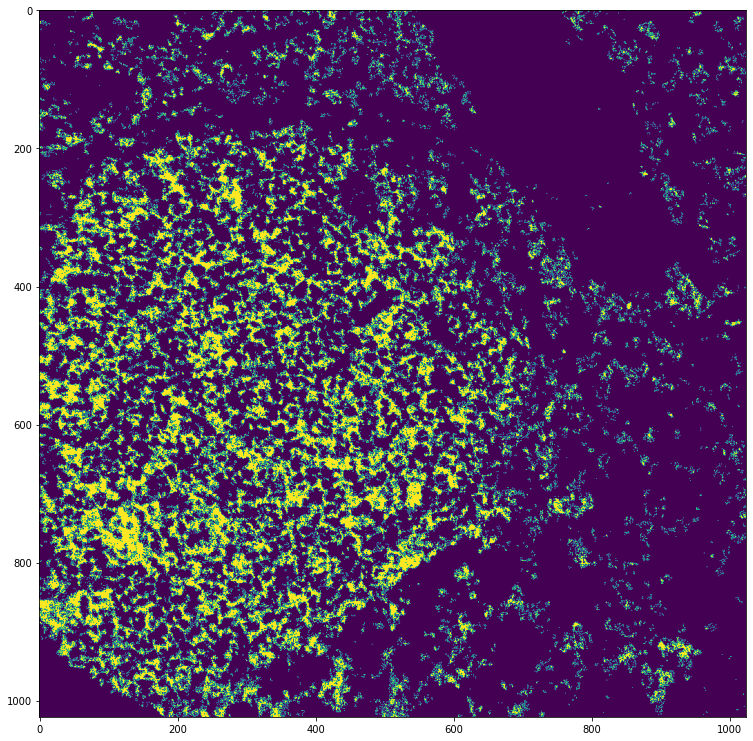

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[3, :, :, 1] > 1)

In [15]:
model_output = xr.DataArray(combined,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['pixelwise_interior', 'pixelwise_border', 'watershed_inner', 
                                  'watershed_outer', 'fgbg_foreground', 'pixelwise_sum']],
                         dims=['fovs', 'rows', 'cols', 'models'])
model_output.to_netcdf(os.path.join(data_dir, "deepcell_output.xr"), format="NETCDF3_64BIT")

In [ ]:
def create_nuclear_labels(nuc_img, labels, percentile):
    nuc_smoothed = nd.gaussian_filter(nuc_img, 2)

    threshold = np.percentile(nuc_smoothed[nuc_smoothed > 0], [percentile])
    nuc_mask = nuc_smoothed < threshold
    nuc_labels = copy.copy(labels)
    nuc_labels[nuc_mask] = 0

    return nuc_labels

In [81]:
nuc_mask = pixelwise[:, :, :, 1:2] < 0.5
nuc_labels = data_npz['y']

In [82]:
nuc_labels[nuc_mask] = 0

In [89]:
np.savez('/data/npz_data/20200315_IF_Training_5_nuc_prob_0.5.npz', X=data_npz['X'], y=nuc_labels)

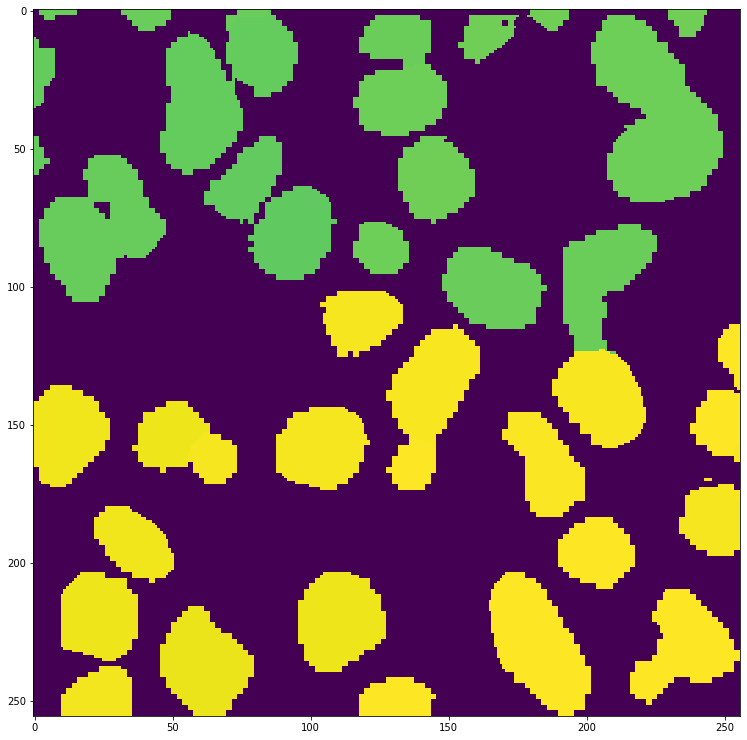

In [88]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(nuc_labels[950, :, :, 0])